# <center>Feedforward and Backpropagation</center>
## <center>Inclass Project 2 - MA4144</center>

This project contains 12 tasks/questions to be completed, some require written answers. Open a markdown cell below the respective question that require written answers and provide (type) your answers. Questions that required written answers are given in blue fonts. Almost all written questions are open ended, they do not have a correct or wrong answer. You are free to give your opinions, but please provide related answers within the context.

After finishing project run the entire notebook once and **save the notebook as a pdf** (File menu -> Save and Export Notebook As -> PDF). You are **required to upload this PDF on moodle and also the ipynb notebook file as well**.

***

## Outline of the project

The aim of the project is to build a Multi Layer perceptron (MLP) model from scratch for binary classification. That is given an input $x$ output the associated class label $0$ or $1$.

In particular, we will classify images of handwritten digits ($0, 1, 2, \cdots, 9$). For example, given a set of handwritten digit images that only contain two digits (Eg: $1$ and $5$) the model will classify the images based on the written digit.

For this we will use the MNIST dataset (collection of $28 \times 28$ images of handwritten digits) - you can find additional information about MNIST [here](https://en.wikipedia.org/wiki/MNIST_database).

<img src="https://upload.wikimedia.org/wikipedia/commons/f/f7/MnistExamplesModified.png" width="250">

***


Use the below cell to use any include any imports

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

## Section 1: Preparing the data

In [3]:
#Load the dataset as training and testing, then print out the shapes of the data matrices.
#The training data will be provided to you.

data = np.load('train_mnist.npz')
train_X = data['x']
train_y = data['y']
print(train_X.shape)
print(train_y.shape)

(60000, 28, 28)
(60000,)


**Q1.** In the following cell write code to display $5$ random images in train_X and it's corresponding label in train_y. Each time it is run, you should get a different set of images. The imshow function in the matplotlib library could be useful. Display them as [grayscale images](https://en.wikipedia.org/wiki/Grayscale).

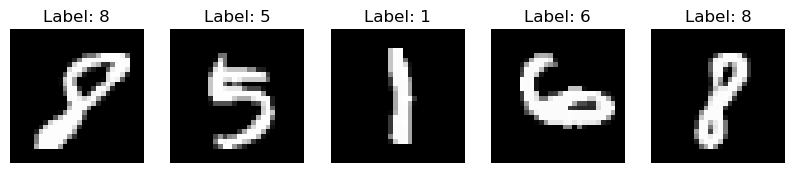

In [4]:
#TODO Code to display 5 random handritten images from train_X and corresponting labels from train_y

random_indices = np.random.choice(train_X.shape[0], size=5, replace=False)

plt.figure(figsize=(10, 5))
for i, idx in enumerate(random_indices):
    plt.subplot(1, 5, i + 1)
    plt.imshow(train_X[idx], cmap='gray')
    plt.title(f"Label: {train_y[idx]}")
    plt.axis('off')
plt.show()

**Q2.** Given two digits $d_1$ and $d_2$, both between $0$ and $9$, in the following cell fill in the function body to extract all the samples corresponding to $d_1$ or $d_2$ only, from the dataset $X$ and labels $y$. You can use the labels $y$ to filter the dataset. Assume that the label for the $i$th image $X[i]$ in $X$ is given by $y[i]$. The function should return the extracted samples $X_{extracted}$ and corresponding labels $y_{extracted}$. Avoid using for loops as much as possible, infact you do not need any for loops. numpy.where function should be useful.

In [5]:
def extract_digits(X, y, d1, d2):

    assert d1 in range(0, 10), "d1 should be a number between 0 and 9 inclusive"
    assert d2 in range(0, 10), "d2 should be a number between 0 and 9 inclusive"
    
    #TODO
    indices = np.where((y == d1) | (y == d2))[0]
    X_extracted = X[indices]
    y_extracted = y[indices]

    return (X_extracted, y_extracted)

**Q3.** Both the training dataset is a 3 dimensional numpy array, each image occupies 2 dimensions. For convenience of processing data we usually comvert each $28 \times 28$ image matrix to a vector with $784$ entries. We call this process **vectorize images**.

Once we vectorize the images, the vectorized data set would be structured as follows: $i$th row will correspond to a single image and $j$th column will correspond to the $j$th pixel value of each vectorized image. However going along with the convention we discussed in the lecture, the input to the MLP model will require that the columns correspond to individual images. Hence we also require a transpose of the vectorized results.

The pixel values in the images will range from $0$ to $255$. Normalize the pixel values between $0$ and $1$, by dividing each pixel value of each image by the maximum pixel value of that image. Simply divide each column of the resulting matrix above by the max of each column. 

<center><img src="https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcTdN_8m9FEqjqAB07obTmB6gNc7S2rSoGBYaA&s"></center>

Given a dataset $X$ of size $N \times 28 \times 28$, in the following cell fill in the function to do the following in order;
1. Vectorize the dataset resulting in dataset of size $N \times 784$.
2. Transpose the vectorized result.
3. Normalize the pixel values of each image.
4. Finally return the vectorized, transposed and normalized dataset $X_{transformed}$.

Again, avoid for loops, functions such as numpy.reshape, numpy.max etc should be useful.

In [6]:
def vectorize_images(X):

    #TODO
    X_vectorized = X.reshape(X.shape[0], -1)
    X_vectorized = X_vectorized.T
    X_vectorized = X_vectorized / 255.0

    return(X_vectorized)

**Q4.** In the following cell write code to;

1. Extract images of the digits $d_1 = 1$ and $d_2 = 5$ with their corresponding labels for the training set (train_X, train_y).
2. Then vectorize the data, tranpose the result and normlize the images.
3. Store the results after the final transformations in numpy arrays train_X_1_5, train_y_1_5.
4. Our MLP will output only class labels $0$ and $1$ (not $1$ and $5$), so create numpy arrays to store the class labels as follows:
   $d_1 = 1$ -> class label = 0 and $d_2 = 5$ -> class label = 1. Store them in an array named train_y_1_5.

Use the above functions you implemented above to complete this task. In addtion, numpy.where could be useful. Avoid for loops as much as possible.

In [7]:
#TODO
#Extract and organize the training data as described above.
#Here you will be using the functions you implemented above appropriately

X_1_5, y_1_5 = extract_digits(train_X, train_y, 1, 5)
train_X_1_5 = vectorize_images(X_1_5)
train_y_1_5 = np.where(y_1_5 == 1, 0, 1)  # Map 1 to 0 and 5 to 1

## Section 2: Implementing MLP from scratch with training algorithms.

Now we will implement code to build a customizable MLP model. The hidden layers will have the **Relu activation function** and the final output layer will have **Sigmoid activation function**.

**Q5.** Recall the following about the activation functions:
1. Sigmoid activation: $y = \sigma(z) = \frac{1}{1 + e^{-z}}$.
2. Derivative of Sigmoid: $y' = \sigma'(z) = \sigma(z) (1 - \sigma(z)) = y(1-y)$
3. ReLu activation: $y = ReLu(z) = max(0, z)$
4. Derivative of ReLu: $y' = ReLu'(z) = \begin{cases} 0 \; \textrm{if } z < 0 \\ 1 \; \textrm{otherwise} \end{cases} = \begin{cases} 0 \; \textrm{if } y = 0 \\ 1 \; \textrm{otherwise} \end{cases}$

In the following cell implement the functions to compute activation functions Sigmoid and ReLu given $z$ and derivatives of the Sigmoid and ReLu activation functions given $y$. Note that, in the implementation, the derivative functions should actually accept $y$ as the input not $z$.

In practice the input will not be just single numbers, but matrices. So functions or derivatives should be applied elementwise on matrices. Again avoid for loops, use the power of numpy arrays - search for numpy's capability of doing elementwise computations.

Important: When implementing the sigmoid function make sure you handle overflows due to $e^{-z}$ being too large. To avoid you can choose to set the sigmoid value to 'the certain appropriate value' if $z$ is less than a certain good enough negative threshold. If you do not handle overflows, the entire result will be useless since the MLP will just output Nan (not a number) for every input at the end.

In [8]:
def sigmoid(Z):

    #TODO
    Z = np.clip(Z, -500, 500)
    sigma = 1 / (1 + np.exp(-Z))
    
    return(sigma)

def deriv_sigmoid(Y):

    #TODO
    sigma_prime = Y * (1 - Y)
    return(sigma_prime)
    

def ReLu(Z):

    #TODO
    relu = np.maximum(0, Z)

    return(relu)

def deriv_ReLu(Y):

    #TODO
    relu_prime = np.where(Y > 0, 1, 0)
    
    return(relu_prime)


**Q6.** The following piece of code defines a simple MLP architecture as a Python class and subsequent initialization of a MLP model. <font color='blue'>Certain lines of code contains commented line numbers. Write a short sentence for each such line explaining its purpose. Feel free to refer to the lecture notes or any resources to answers these question. In addition, explain what the Y, Z, W variables refer to and their purpose</font>

In [9]:
class NNet:
    def __init__(self, input_size = 784, output_size = 1, batch_size = 1000, hidden_layers = [512, 256, 64]):
        self.Y = []
        self.Z = []
        self.W = []
        self.input_size = input_size
        self.output_size = output_size
        self.batch_size = batch_size
        self.hidden_layers = hidden_layers

        layers = [input_size] + hidden_layers + [output_size]
        L = len(hidden_layers) + 1
    
        for i in range(1, L + 1):
            self.Y.append(np.zeros((layers[i], batch_size)))                        #line1
            self.Z.append(np.zeros((layers[i], batch_size)))                        #Line2
            self.W.append(2*(np.random.rand(layers[i], layers[i-1] + 1) - 0.5))     #Line3

**Questions** (write answers in the cell below as strings)

(i) What does the Y, Z, W variables refer to and their purpose?

(ii) Line1: Explanation

(iii) Line2: Explanation

(iv) Line3: Explanation

In [10]:
#Write answers here as strings:

ans_i = "Y, Z, and W are lists used to store the activations (Y), pre-activations (Z), and weights (W) for each layer of the neural network. Y holds the output of each layer after applying the activation function, Z holds the linear combination of inputs and weights before activation, and W holds the weight matrices (including bias) for each layer."
ans_ii = "Line1 initializes the activations Y for each layer as zero matrices of appropriate shape, to store the output of each layer during forward propagation."
ans_iii = "Line2 initializes the pre-activations Z for each layer as zero matrices of appropriate shape, to store the linear combinations of inputs and weights before activation."
ans_iv = "Line3 initializes the weights W for each layer with small random values in the range [-1, 1], including an extra column for the bias term, to break symmetry and allow for effective learning."


**Q7.** Now we will implement the feedforward algorithm. Recall from the lectures that for each layer $l$ there is input $Y^{(l-1)}$ from the previous layer if $l > 1$ and input data $X$ if $l = 1$. Then we compute $Z^{(l)}$ using the weight matrix $W^{(l)}$ as follows from matrix multiplication:

$Z^{(l)} = W^{(l)} Y^{(l-1)}$

Make sure that during multiplication you add an additional row of one's to $Y^{(l-1)}$ to accommodate the bias term (concatenate the row of ones as the last row to be consistent with the grader). However, the rows of ones should not permanently remain on $Y^{(l-1)}$. <font color='blue'>Explain what the bias term is and how adding a row of one's help with the bias terms.</font> The weight matrices are initialised to afford this extra bias term, so no change to either $Z^{(l)}$ or $W^{(l)}$ is needed.

Next compute $Y^{(l)}$, the output of layer $l$ by activation through sigmoid.

$Y^{(l)} = \sigma(Z^{(l)})$

The implemented feedforward algorithm should take in a NNet model and an input matrix $X$ and output the modified MLP model - the $Y$'s and $Z$'s computed should be stored in the model for the backpropagation algorithm.

As usual, avoid for loops as much as possible, use the power of numpy. However, you may use a for loop to iterate through the layers of the model.

In [11]:
def feedforward(model, X):

    #TODO
    A = X

    for l in range(len(model.W)):
        A_with_bias = np.vstack([A, np.ones((1, A.shape[1]))])  # Add bias term
        Z = model.W[l] @ A_with_bias
        model.Z[l][:, :Z.shape[1]] = Z

        if l == len(model.W) - 1:
            A = sigmoid(Z)
        else:
            A = ReLu(Z)
        model.Y[l][:, :A.shape[1]] = A

    return(model)

**Question** (write answer in the cell below as a string)

Explain what the bias term is and how adding a row of one's help with the bias terms.

In [12]:
#Write the answer here as a string:

ans_bias = "The bias term in a neural network is an extra parameter added to each neuron that allows the activation function to be shifted left or right, improving the model's flexibility. By adding a row of ones to the input (or activations), we can include the bias in the weight matrix multiplication, treating it as an additional weight. This makes the computation efficient and ensures each neuron has its own bias term, which helps the network learn patterns that do not pass through the origin."

**Q8.** Now we will implement the backpropagation algorithm. The cost function $C$ at the end is given by the square loss.

$C = \frac{1}{2} ||Y^{(L)} - Y||^{2}$, where $Y^{(L)}$ is the final output vector of the feedforward algorithm and $Y$ is the actual label vector associated with the input $X$.

At each layer $l = 1, 2, \cdots, L$ we compute the following (note that the gradients are matrices with the same dimensions as the variable to which we derivating with respect to):

1. Gradient of $C$ with respect to $Z^{(l)}$ as <br> $\frac{\partial C}{\partial Z^{(l)}} = deriv(A^{(l)}(Z^{(l)})) \odot \frac{\partial C}{\partial Y^{(L)}} $, <br> where $A^{(l)}$ is the activation function of the $l$th layer, and we use the derivative of that here. The $\odot$ refers to the elementwise multiplication.

2. Gradient of $C$ with respect to $W^{(l)}$ as <br> $\frac{\partial C}{\partial W^{(l)}} = \frac{\partial C}{\partial Z^{(l)}} (Y^{(l-1)})^{T}$ <br> this is entirely matrix multiplication.

3. Gradient of $C$ with respect to $Y^{(l-1)}$ as <br> $\frac{\partial C}{\partial Y^{(l-1)}} = (W^{(l)})^{T} \frac{\partial C}{\partial Z^{(l)}}$ <br> this is also entirely matrix multiplication.

4. Update weights by: <br> $W^{(l)} \leftarrow W^{(l)} - \eta \frac{\partial C}{\partial W^{(l)}}$, <br> where $\eta > 0$ is the learning rate.

The loss derivative (the gradient of $C$ with respect to $Y^{(L)}$) at the last layer is given by:

$\frac{\partial C}{\partial Y^{(L)}} = Y^{(L)} - Y$

By convention we consider $Y^{(0)} = X$, the input data.

Based on the backpropagation algorithm implement the backpropagation method in the following cell. Remember to temporarily add a row of ones to $Y^{(l-1)}$ (as the last row to be consistent with the grader) when computing $\frac{\partial C}{\partial W^{(l)}}$ as we discussed back in the feedforward algorithm. Make sure you avoid for loops as much as possible.

The function takes in a NNet model, input data $X$ and the corresponding class labels $Y$. learning rate can be set as desired.

In [13]:
def backpropagation(model, X, Y, eta = 0.01):

    #TODO
    L = len(model.W)
    grads_Z = [None] * L
    grads_W = [None] * L

    dC_dY = model.Y[-1][:, :Y.shape[1]] - Y  

    for l in reversed(range(L)):
        Y_l = model.Y[l][:, :X.shape[1]] 
        Z_l = model.Z[l][:, :X.shape[1]]

        if l == 0:
            Y_prev = X
        else:
            Y_prev = model.Y[l-1][:, :Y.shape[1]]
        
        if l == L - 1:
            deriv = deriv_sigmoid(Y_l)
        else:
            deriv = deriv_ReLu(Y_l)

        grads_Z[l] = deriv * dC_dY

        Y_prev_with_bias = np.vstack([Y_prev, np.ones((1, Y_prev.shape[1]))])
        grads_W[l] = np.dot(grads_Z[l], Y_prev_with_bias.T)

        W_no_bias = model.W[l][:, :-1].T
        dC_dY = np.dot(W_no_bias, grads_Z[l])
    
    for l in range(L):
        model.W[l] -= eta * grads_W[l] 

    return(model)

**Q9.** Now implement the training algorithm.

The training method takes in training data $X$, actual label $Y$, number of epochs, batch_size, learning rate $\eta > 0$. The training will happen in epochs. For each epoch, permute the data columns of both $X$ and $Y$, then divide both $X$ and $Y$ into mini batches each with the given batch size. Then run the feedforward and backpropagation for each such batch iteratively.

At the end of each iteration, keep trach of the cost $C$ and the $l_2$-norm of change in each weight matrix $W^{(l)}$.

At the end of the last epoch, plot the variation cost $C$ and change in weight matrices. Then return the trained model.



In [14]:
def train_NNet(X, Y, epochs = 20, batch_size = 1000, eta = 0.01):

    #TODO

    input_size = X.shape[0]
    output_size = Y.shape[0]

    model = NNet(input_size=input_size, output_size=output_size, batch_size=batch_size)

    num_samples = X.shape[1]
    num_batches = int(np.ceil(num_samples / batch_size))
    L = len(model.W)

    cost_history = []
    weight_change_history = [[] for _ in range(L)]

    for epoch in range(epochs):
        perm = np.random.permutation(num_samples)
        X_shuffled = X[:, perm]
        Y_shuffled = Y[:, perm]

        for b in range(num_batches):
            start = b * batch_size
            end = min((b + 1) * batch_size, num_samples)

            X_batch = X_shuffled[:, start:end]
            Y_batch = Y_shuffled[:, start:end]

            current_batch_size = X_batch.shape[1]
            if current_batch_size != model.batch_size:
                model.batch_size = current_batch_size
                for l in range(L):
                    model.Y[l] = np.zeros((model.Y[l].shape[0], X_batch.shape[1]))
                    model.Z[l] = np.zeros((model.Z[l].shape[0], X_batch.shape[1]))
            
            old_W = [w.copy() for w in model.W]

            model = feedforward(model, X_batch)
            model = backpropagation(model, X_batch, Y_batch, eta)

            Y_pred = model.Y[-1][:, :Y_batch.shape[1]]
            cost = 0.5 * np.sum((Y_pred - Y_batch) ** 2) / Y_batch.shape[1]
            cost_history.append(cost)

            for l in range(L):
                delta = np.linalg.norm(model.W[l] - old_W[l])
                weight_change_history[l].append(delta)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(cost_history)
    plt.title("Cost over iterations")
    plt.xlabel("Iteration")
    plt.ylabel("Cost")

    plt.subplot(1, 2, 2)
    for l in range(L):
        plt.plot(weight_change_history[l], label=f'Layer {l+1}')
    plt.title("L2 norm of weight changes")
    plt.xlabel("Iteration")
    plt.ylabel("L2 norm")
    plt.legend()
    plt.tight_layout()
    plt.show()

    return(model)

## Section 3: Evaluation using test data

**Q10.** Implement the following function predict. Given test images (3 dimensional numpy array that contains $28 \times 28$ digit images) it will correctly recognize the written digits between d1 and d2. You can assume that test_images will only contain images of digits d1 and d2. Inside predict you would need to preprocess the images using vectorize, predict the correct labels using model and then output the correct lables. Output should be a vector predicted of d1's and d2's, predicted[i] should correspond to the test_image[i].

In [15]:
def predict(model, test_images, d1, d2):

    #TODO
    X_test = vectorize_images(test_images)
    test_batch_size = X_test.shape[1]
    L = len(model.W)

    if test_batch_size != model.batch_size:
        model.batch_size = test_batch_size
        for l in range(L):
            model.Y[l] = np.zeros((model.Y[l].shape[0], test_batch_size))
            model.Z[l] = np.zeros((model.Z[l].shape[0], test_batch_size))

    model = feedforward(model, X_test)
    Y_pred = model.Y[-1][:, :X_test.shape[1]]

    class_pred = (Y_pred >= 0.5).astype(int).flatten()

    predicted = np.where(class_pred == 0, d1, d2)
    
    return(predicted)

**Q11.** Use the train_NNet function to train a MLP model to classify between images of digits $1$ and $5$. An accuracy $>= 99%$ is achievable. Test with different batch sizes, $\eta$ values and hidden layers. Find which of those hyperparameters gives the best test accuracy. Name this model, model_1_5. This model will be tested on unseen test data within the grader. So make sure you train the best possible model. The grader will use your own predict function to evaluate the model.

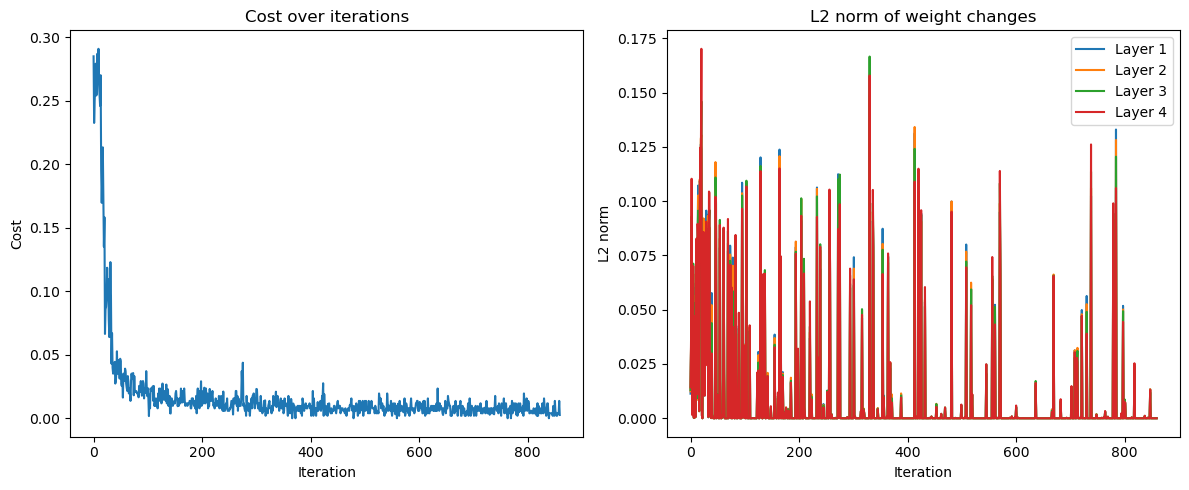

In [16]:
#TODO

# Y_train = train_y_1_5.reshape(1, -1)

# best_batch_size = 128
# best_eta = 0.01
# best_hidden_layers = [256, 64]

# class NNetCustom(NNet):
#     def __init__(self, input_size=784, output_size=1, batch_size=best_batch_size, hidden_layers=best_hidden_layers):
#         super().__init__(input_size, output_size, batch_size, hidden_layers)

# def train_best_model():
#     model = NNetCustom(batch_size=best_batch_size, hidden_layers=best_hidden_layers)
#     epochs = 25
#     for epoch in range(epochs):
#         print(f"Epoch {epoch+1}/{epochs}")
#         # Shuffle and batch logic is inside train_NNet, so we call it for one epoch at a time
#         model = train_NNet(train_X_1_5, Y_train, epochs=1, batch_size=best_batch_size, eta=best_eta)
#     return model

# model_1_5 = train_best_model()


#TODO
Y_train = train_y_1_5.reshape(1, -1)

best_batch_size = 256
best_eta = 0.0005
best_hidden_layers = [500, 250, 50]

# Split a small part for validation (e.g., 10%)
num_samples = train_X_1_5.shape[1]
val_size = int(0.1 * num_samples)
indices = np.random.permutation(num_samples)
val_indices = indices[:val_size]
train_indices = indices[val_size:]

X_train = train_X_1_5[:, train_indices]
y_train = Y_train[:, train_indices]
X_val = train_X_1_5[:, val_indices]
y_val = Y_train[:, val_indices]

model = train_NNet(X_train, y_train, epochs=20, batch_size=256, eta=0.0005)

model_1_5 = model

In [17]:
train_pred = predict(model_1_5, X_1_5, 1, 5)
true_labels = np.where(train_y_1_5 == 0, 1, 5)  # Map 0->1, 1->5 for comparison
acc = accuracy_score(true_labels, train_pred)
print(f"Training accuracy: {acc * 100:.2f}%")

Training accuracy: 98.91%


In [18]:
val_pred = predict(model_1_5, X_val.reshape(28, 28, -1).transpose(2, 0, 1), 1, 5)
true_labels = np.where(y_val.flatten() == 0, 1, 5)
acc = accuracy_score(true_labels, val_pred)

print(f"Validation Accuracy: {acc * 100:.2f}%")

Validation Accuracy: 45.81%


**Q12.** Do the same as in Q11 with the digits $7$ and $9$ Name this model, model_7_9. This model will be tested on unseen test data within the grader. So make sure you train the best possible model. The grader will use your own predict function to evaluate the model.

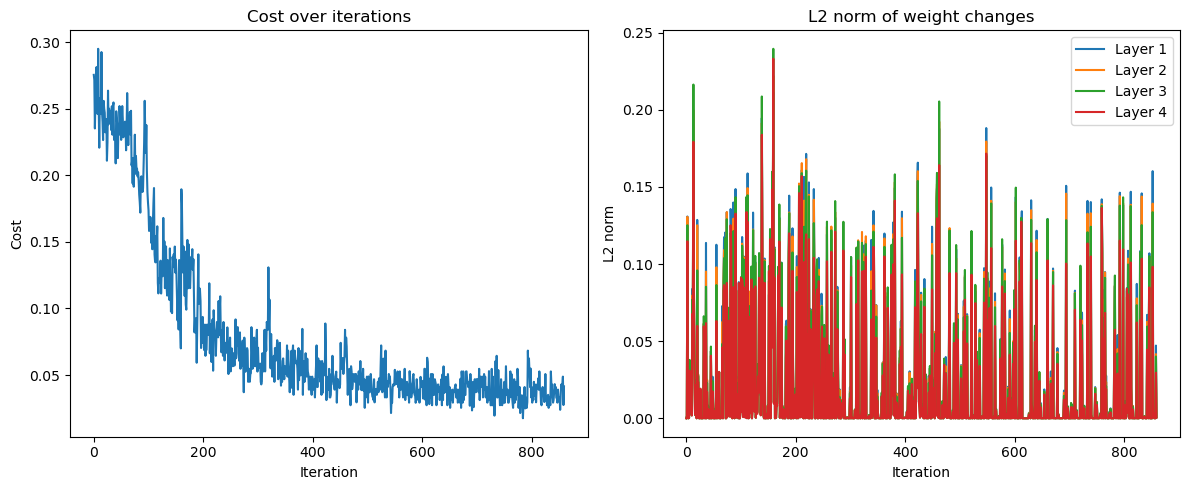

Training accuracy (7 vs 9): 93.12%
Validation accuracy (7 vs 9): 49.47%


In [20]:
# Extract and organize the training data for digits 7 and 9
X_7_9, y_7_9 = extract_digits(train_X, train_y, 7, 9)
train_X_7_9 = vectorize_images(X_7_9)
train_y_7_9 = np.where(y_7_9 == 7, 0, 1)  # Map 7 to 0 and 9 to 1

Y_train_7_9 = train_y_7_9.reshape(1, -1)

# Split a small part for validation (e.g., 10%) without sklearn
num_samples_7_9 = train_X_7_9.shape[1]
val_size_7_9 = int(0.1 * num_samples_7_9)
indices_7_9 = np.random.permutation(num_samples_7_9)
val_indices_7_9 = indices_7_9[:val_size_7_9]
train_indices_7_9 = indices_7_9[val_size_7_9:]

X_train_7_9 = train_X_7_9[:, train_indices_7_9]
y_train_7_9 = Y_train_7_9[:, train_indices_7_9]
X_val_7_9 = train_X_7_9[:, val_indices_7_9]
y_val_7_9 = Y_train_7_9[:, val_indices_7_9]

# You can tune these hyperparameters as needed
best_batch_size_7_9 = 256
best_eta_7_9 = 0.0005
best_hidden_layers_7_9 = [500, 250, 50]

# Train the model
model_7_9 = train_NNet(X_train_7_9, y_train_7_9, epochs=20, batch_size=best_batch_size_7_9, eta=best_eta_7_9)

# Optional: Evaluate on training and validation set
train_pred_7_9 = predict(model_7_9, X_7_9, 7, 9)
true_labels_7_9 = np.where(train_y_7_9 == 0, 7, 9)
acc_train_7_9 = accuracy_score(true_labels_7_9, train_pred_7_9)
print(f"Training accuracy (7 vs 9): {acc_train_7_9 * 100:.2f}%")

val_pred_7_9 = predict(model_7_9, X_val_7_9.reshape(28, 28, -1).transpose(2, 0, 1), 7, 9)
true_labels_val_7_9 = np.where(y_val_7_9.flatten() == 0, 7, 9)
acc_val_7_9 = accuracy_score(true_labels_val_7_9, val_pred_7_9)
print(f"Validation accuracy (7 vs 9): {acc_val_7_9 * 100:.2f}%")